# Day 31 – Word2Vec Semantic Search
### Train Word2Vec and Build Internal Semantic Search Engine

Today you will: 
- Train a Word2Vec model using Gensim
- Convert sentences into embedding vectors
- Perform semantic search using cosine similarity
- Retrieve the most meaningful FAQ answer

This is one step closer to embedding-based RAG and LLM pipelines.

In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

print('Libraries loaded.')

Libraries loaded.


## 1. Synthetic FAQ Dataset

In [2]:
faq_data = {
    "question": [
        "How do I reset my password?",
        "Why is my payment failing?",
        "How to update my billing email?",
        "App keeps crashing when uploading files.",
        "How can I change my subscription plan?",
        "I cannot login to my account.",
        "The dashboard is not loading properly.",
        "How to contact customer support?",
        "My screen freezes after the new update.",
        "Billing amount deducted twice."
    ]
}

df = pd.DataFrame(faq_data)
df

,question
0,How do I reset my password?
1,Why is my payment failing?
2,How to update my billing email?
3,App keeps crashing when uploading files.
4,How can I change my subscription plan?
5,I cannot login to my account.
6,The dashboard is not loading properly.
7,How to contact customer support?
8,My screen freezes after the new update.
9,Billing amount deducted twice.


## 2. Text Cleaning + Tokenization

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean'] = df['question'].apply(clean_text)
df['tokens'] = df['clean'].apply(lambda x: x.split())

df[['question','tokens']]

,question,tokens
0,How do I reset my password?,"[how, do, i, reset, my, password]"
1,Why is my payment failing?,"[why, is, my, payment, failing]"
2,How to update my billing email?,"[how, to, update, my, billing, email]"
3,App keeps crashing when uploading files.,"[app, keeps, crashing, when, uploading, files]"
4,How can I change my subscription plan?,"[how, can, i, change, my, subscription, plan]"
5,I cannot login to my account.,"[i, cannot, login, to, my, account]"
6,The dashboard is not loading properly.,"[the, dashboard, is, not, loading, properly]"
7,How to contact customer support?,"[how, to, contact, customer, support]"
8,My screen freezes after the new update.,"[my, screen, freezes, after, the, new, update]"
9,Billing amount deducted twice.,"[billing, amount, deducted, twice]"


## 3. Train Word2Vec Model (Gensim)

In [4]:
# Train Word2Vec
model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # Skip-gram for better semantic learning
)

model.save("word2vec_faq.model")
print('Word2Vec model trained and saved.')

Word2Vec model trained and saved.


## 4. Convert FAQ Sentences → Sentence Embeddings
Average word embeddings = sentence embedding.

In [5]:
def sentence_embedding(tokens):
    vectors = []
    for t in tokens:
        if t in model.wv:
            vectors.append(model.wv[t])
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['embedding'] = df['tokens'].apply(sentence_embedding)
df[['question','embedding']].head()

,question,embedding
0,How do I reset my password?,"[-0.0050739893, 0.004031034, -0.00092302513, -..."
1,Why is my payment failing?,"[0.0014925267, -0.0017428733, 0.0019042764, 0...."
2,How to update my billing email?,"[-0.00028582988, -0.00030373046, 0.001225185, ..."
3,App keeps crashing when uploading files.,"[0.00057378155, -0.0055980827, -0.001256324, 0..."
4,How can I change my subscription plan?,"[-0.00060723774, 0.003313013, -0.001169712, 0...."


## 5. Semantic Search Function

In [6]:
def semantic_search(query, top_k=3):
    query = clean_text(query)
    q_tokens = query.split()
    q_embedding = sentence_embedding(q_tokens).reshape(1, -1)

    faq_embeddings = np.vstack(df['embedding'].values)
    similarities = cosine_similarity(q_embedding, faq_embeddings).flatten()

    top_idx = similarities.argsort()[::-1][:top_k]

    results = []
    for idx in top_idx:
        results.append({
            'faq_index': int(idx),
            'question': df.iloc[idx]['question'],
            'similarity': float(similarities[idx])
        })
    return results, similarities

query = "The app crashes whenever I upload a file."
semantic_search(query)[0]

[{'faq_index': 5,
  'question': 'I cannot login to my account.',
  'similarity': 0.33851689100265503},
 {'faq_index': 8,
  'question': 'My screen freezes after the new update.',
  'similarity': 0.31010204553604126},
 {'faq_index': 0,
  'question': 'How do I reset my password?',
  'similarity': 0.2862917482852936}]

## 6. Visualize Similarity Scores

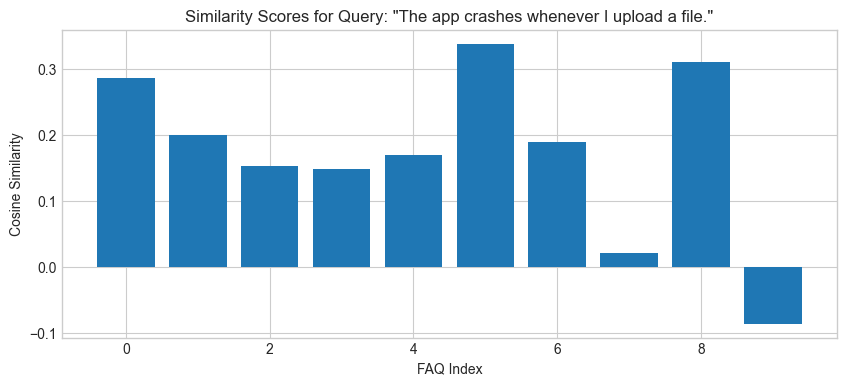

In [7]:
results, sims = semantic_search(query, top_k=3)

plt.figure(figsize=(10,4))
plt.bar(range(len(sims)), sims)
plt.title(f'Similarity Scores for Query: "{query}"')
plt.xlabel('FAQ Index')
plt.ylabel('Cosine Similarity')
plt.show()

## 7. Summary
- Cleaned + tokenized text
- Trained Word2Vec (semantic embeddings)
- Converted sentences → sentence vectors
- Implemented semantic cosine search
- Retrieved best matching FAQ
- Visualized similarity scores

**Deliverable:** `day31_word2vec_semantic_search.ipynb`